In [2]:
SAVE = True

Combine relevant evaluation files into a single file

In [3]:
import sys
sys.path.append('..')
import os
import pandas as pd
import eval_reallabor_utils
import data_utils

MRT = [2, 3]
combined_eval_file = []

for mrt in MRT:

    results_dirs = [
        f'v3_MRT{mrt}_SimpleModels_every_day/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_Kalman_every_day/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_every_day/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_Transformer_every_day/00_summary_7stepsahead_interv'
        ]

    eval_files = []
    for rd in results_dirs:
        eval_files.append(data_utils.join_ordinal_bptt_path('results', rd, 'evaluation.csv'))
        assert os.path.exists(eval_files[-1]), eval_files[-1]
    eval_reallabor_utils.clear_line_and_print(f'Combining evaluation files')
    mrt_combined_eval_file = eval_reallabor_utils.combine_evaluation_files(eval_files, save_path=None, specifier_name='latent_model')
    mrt_combined_eval_file['MRT'] = mrt

    use_days_from_file = data_utils.train_test_split_path(mrt, 'valid_first_alarms_no_con_smoothed.csv')
    valid_days = pd.read_csv(use_days_from_file, index_col=0)
    valid_days.columns = [int(c) for c in valid_days.columns]

    eval_reallabor_utils.clear_line_and_print(f'Filtering out invalid days')
    eval_only_valid_days = []
    for p, group in mrt_combined_eval_file.groupby('participant'):
        if p in valid_days.columns:
            eval_only_valid_days.append(group.loc[group['test_day'].isin(valid_days[p])])
    mrt_combined_eval_file = pd.concat(eval_only_valid_days, axis=0, ignore_index=True)
    
    mrt_combined_eval_file['prediction'] = mrt_combined_eval_file['prediction'].clip(0, 8)

    combined_eval_file.append(mrt_combined_eval_file)

eval_reallabor_utils.clear_line_and_print(f'Creating grand combined evaluation file')
combined_eval_file = pd.concat(combined_eval_file, axis=0, ignore_index=False)
if not os.path.exists(data_utils.join_ordinal_bptt_path('results/_paper/combined_every_day_ensemble.csv')):
    os.makedirs(data_utils.join_ordinal_bptt_path('results/_paper'), exist_ok=True)
    combined_eval_file.to_csv(data_utils.join_ordinal_bptt_path('results/_paper/combined_every_day_ensemble.csv'))

if 'train_until' in combined_eval_file.columns:
    combined_eval_file.loc[combined_eval_file['latent_model']=='hierarchized clipped-shallow-PLRNN', 'latent_model'] = 'hierarchized-clipped-shallow-PLRNN'
    combined_eval_file.loc[combined_eval_file['train_until'].isna(), 'train_until'] = combined_eval_file.loc[combined_eval_file['train_until'].isna(), 'train_on_data_until_timestep']

Creating grand combined evaluation file                                                                                                                                                                 

Create metrics manager

In [4]:
from eval_reallabor import reallabor_metrics
m_manager = reallabor_metrics.MetricsManager(combined_eval_file, ['MRT', 'latent_model'], use_gt_for_predicted_difference=False, only_nonzero_differences=True)

Use mean and bootstrap confidence intervals with 90% confidence

In [ ]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    # ci_manager_within_subj = reallabor_metrics.BootstrapConfidenceIntervals(combined_eval_file, ['MRT', 'latent_model'], bootstrap_samples, within_subjects=True, num_workers=32)
    # ci_manager_within_subj_change = reallabor_metrics.BootstrapConfidenceIntervals(change_combined_eval_file, ['MRT', 'latent_model'], bootstrap_samples, within_subjects=True, num_workers=32)
ci_manager_between_subj = reallabor_metrics.BootstrapConfidenceIntervals(combined_eval_file, ['MRT', 'latent_model'], 100, within_subjects=False, num_workers=32)

metrics, errorbars = {}, {}
metrics['mae'], errorbars['mae'] = ci_manager_between_subj.get_metric_ci('mae', confidence=90, func='mean')
# metrics['diff_mae'], errorbars['diff_mae'] = ci_manager.diff_mae()
metrics['change mae'], errorbars['change mae'] = ci_manager_between_subj.get_metric_ci('change_mae', confidence=90, func='mean')
# metrics['r2'], errorbars['r2'] = ci_manager_within_subj.get_metric_ci('r2', confidence=50, relative_to={'latent_model': 'clipped-shallow-PLRNN'})
# metrics['change r2'], errorbars['change r2'] = ci_manager_within_subj_change.get_metric_ci('r2', confidence=50, relative_to={'latent_model': 'clipped-shallow-PLRNN'})
metrics['change sign correct'], errorbars['change sign correct'] = ci_manager_between_subj.get_metric_ci('change_sign_correct', confidence=90, func='mean')
metrics[r'$\Delta$ interv. mae'], errorbars[r'$\Delta$ interv. mae'] = ci_manager_between_subj.get_metric_ci('delta_interv_mae', confidence=90, func='mean')

Use median and interquartile range for confidence intervals

In [35]:
metrics, errorbars = {}, {}
metrics['mae'] = m_manager.mae(func='median')
errorbars['mae'] = m_manager.mae(func='quantile', q=[0.25, 0.75]).unstack(level=2).subtract(m_manager.mae(), axis=0).abs()
metrics['change mae'] = m_manager.change_mae(func='median')
errorbars['change mae'] = m_manager.change_mae(func='quantile', q=[0.25, 0.75]).unstack(level=2).subtract(m_manager.change_mae(), axis=0).abs()
metrics['change sign correct'] = m_manager.change_sign_correct(func='median')
errorbars['change sign correct'] = m_manager.change_sign_correct(func='quantile', q=[0.25, 0.75]).unstack(level=2).subtract(m_manager.change_sign_correct(), axis=0).abs()
metrics[r'$\Delta$ interv. mae'] = m_manager.delta_interv_mae(func='median')
errorbars[r'$\Delta$ interv. mae'] = m_manager.delta_interv_mae(func='quantile', q=[0.25, 0.75]).unstack(level=2).subtract(m_manager.delta_interv_mae(), axis=0).abs()

Use median and median absolute deviation for confidence intervals

In [ ]:
metrics, errorbars = {}, {}
metrics['mae'] = m_manager.mae(func='median')
errorbars['mae'] = m_manager.mae(func=lambda x: (x - x.median()).abs().median())
metrics['change mae'] = m_manager.change_mae(func='median')
errorbars['change mae'] = m_manager.change_mae(func=lambda x: (x - x.median()).abs().median())
metrics['change sign correct'] = m_manager.change_sign_correct(func='median')
errorbars['change sign correct'] = m_manager.change_sign_correct(func=lambda x: (x - x.median()).abs().median())
metrics[r'$\Delta$ interv. mae'] = m_manager.delta_interv_mae(func='median')
errorbars[r'$\Delta$ interv. mae'] = m_manager.delta_interv_mae(func=lambda x: (x - x.median()).abs().median())

Use mean and standard error for confidence intervals

In [5]:
metrics, errorbars = {}, {}
# m_manager.raw_metrics.loc[(12, 2, 'KalmanFilter'), 'delta_interv_change_abs_residuals'] = np.nan
metrics['mae'] = m_manager.mae(func='mean')
errorbars['mae'] = m_manager.mae(func='sem')

metrics['interv mae'] = m_manager.interv_mae(func='mean')
errorbars['interv mae'] = m_manager.interv_mae(func='sem')

# metrics['change mae'] = m_manager.change_mae(func='mean')
# errorbars['change mae'] = m_manager.change_mae(func='sem')
# metrics['diff mae'] = m_manager.diff_mae(func='mean')
# errorbars['diff mae'] = m_manager.diff_mae(func='sem')

# metrics['change sign correct'] = m_manager.change_sign_correct(func='mean')
# errorbars['change sign correct'] = m_manager.change_sign_correct(func='sem')

# metrics[r'interv. effect mae'] = m_manager.interv_diff_mae(func='mean')
# errorbars[r'interv. effect mae'] = m_manager.interv_diff_mae(func='sem')
# metrics['delta interv effect mae'] = m_manager.delta_interv_diff_mae(func='mean')
# errorbars['delta interv effect mae'] = m_manager.delta_interv_diff_mae(func='sem')

# metrics['delta interv mae'] = m_manager.delta_interv_mae(func='mean')
# errorbars['delta interv mae'] = m_manager.delta_interv_mae(func='sem')
# metrics['interv change sign correct'] = m_manager.interv_change_sign_correct(func='mean')
# errorbars['interv change sign correct'] = m_manager.interv_change_sign_correct(func='sem')

Plot metrics

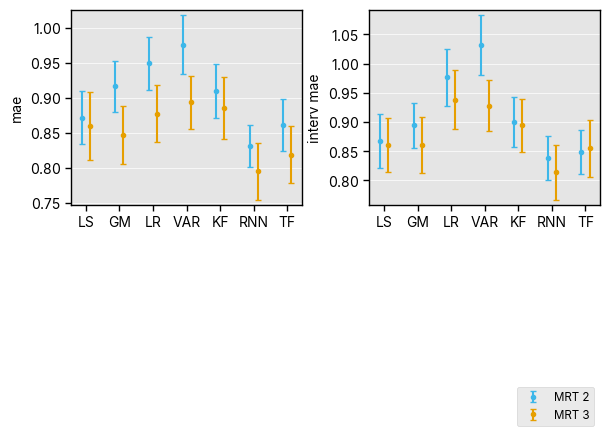

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
from plotting_utils import adjust_ylim

model_labels = {
                    'MovingAverage(1)': 'LS', 'MeanPredictor': 'GM', 'InputsRegression': 'LR', 
                    'VAR1': 'VAR', 'KalmanFilter': 'KF', 
                    'clipped-shallow-PLRNN': 'RNN', 
                    # 'hierarchized-clipped-shallow-PLRNN': 'H-PLRNN',
                    'Transformer': 'TF'
                    }

with PaperStyle():

    color_cycle = ["#3DB7E9", "#e69f00"]
    offset = [-0.12, 0.12]

    ''' COMBINE BOTH MRTS INTO ONE PLOT '''
    fig, axes = plt.subplots(1, len(metrics), figsize=(1+2.6*len(metrics), 2.5), sharex=True)
    axes = axes.flatten()
    for i, m in enumerate(metrics):
        for k, mrt in enumerate(MRT):
            this_line = metrics[m].loc[mrt].loc[model_labels.keys()]
            this_errorbars = errorbars[m].loc[mrt].loc[model_labels.keys()].T
            axes[i].errorbar(np.arange(len(model_labels))+offset[k], this_line, yerr=this_errorbars, linestyle='', marker='.', label=f'MRT {mrt}')
        ylim = axes[i].get_ylim()
        # for k, mrt in enumerate(MRT):
        #     for l, model in enumerate(model_labels.keys()):
        #         if sig[m].loc[(mrt, model), 'clipped-shallow-PLRNN']:
        #             axes[i].text(l+offset[k], ylim[1], '*', fontsize=12, color=color_cycle[k], ha='center', va='bottom')
        axes[i].set(ylabel=m, xticks=range(len(model_labels)))
        axes[i].set_xticklabels(model_labels.values(), rotation=0)#, ha='right')
        adjust_ylim(axes[i], 0.03, 0.03)
    plt.tight_layout()
    axes[-1].legend(bbox_to_anchor=(1, -0.9))
    if SAVE:
        plt.savefig('../results/_paper/model_comparison/model_comparison_every_day_ensemble.svg', dpi=300)

    plt.show()



Display metrics as table

In [8]:
model_labels = {
                    'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    # 'hierarchized-clipped-shallow-PLRNN': 'H-PLRNN',
                    'Transformer': 'Transformer'
                    }
human_readable_metrics = (pd.DataFrame(metrics).loc[pd.IndexSlice[[2,3], model_labels.keys()], :].round(3).map(str)
                          + ' \u00b1 '
                          + pd.DataFrame(errorbars).loc[pd.IndexSlice[[2,3], model_labels.keys()], :].round(4).map(str))
human_readable_metrics

mae      interv mae
MRT latent_model                                         
2   MovingAverage(1)       0.872 ± 0.0382  0.868 ± 0.0461
    MeanPredictor          0.917 ± 0.0363  0.895 ± 0.0384
    InputsRegression        0.95 ± 0.0379  0.976 ± 0.0482
    VAR1                   0.976 ± 0.0422  1.031 ± 0.0515
    KalmanFilter            0.91 ± 0.0385    0.9 ± 0.0434
    clipped-shallow-PLRNN    0.831 ± 0.03  0.838 ± 0.0374
    Transformer            0.861 ± 0.0367  0.848 ± 0.0374
3   MovingAverage(1)        0.86 ± 0.0485  0.861 ± 0.0459
    MeanPredictor           0.847 ± 0.041  0.861 ± 0.0481
    InputsRegression        0.877 ± 0.041  0.938 ± 0.0511
    VAR1                   0.894 ± 0.0381  0.928 ± 0.0438
    KalmanFilter           0.886 ± 0.0439  0.894 ± 0.0449
    clipped-shallow-PLRNN  0.795 ± 0.0407  0.814 ± 0.0469
    Transformer            0.819 ± 0.0411  0.855 ± 0.0485

Test MAE of all models against PLRNN

In [9]:
test = m_manager.ttest

test_results = test('abs_residuals', separately_for_each=['MRT'])
test_results['pvalue'] *= test_results.index.get_level_values('latent_model').unique().size - 1

if test==m_manager.ttest:
    human_readable_test_results = ('t(' 
                                   + test_results[('df', 'clipped-shallow-PLRNN')].astype(str)
                                   + ')='
                                   + test_results[('statistic', 'clipped-shallow-PLRNN')].map(lambda x: f"{x:.3f}")
                                   + ', p='
                                   + test_results[('pvalue', 'clipped-shallow-PLRNN')].map(lambda x: f"{x:.3f}"))
else:
    human_readable_test_results = ('W='
                                   + test_results[('statistic', 'clipped-shallow-PLRNN')].map(lambda x: f"{x:.3f}")
                                   + ', p='
                                   + test_results[('pvalue', 'clipped-shallow-PLRNN')].map(lambda x: f"{x:.3f}"))

human_readable_test_results

MRT  latent_model         
2    InputsRegression         t(47)=8.442, p=0.000
     KalmanFilter             t(45)=3.861, p=0.002
     MeanPredictor            t(47)=5.709, p=0.000
     MovingAverage(1)         t(47)=2.136, p=0.228
     Transformer              t(47)=1.876, p=0.401
     VAR1                     t(47)=4.812, p=0.000
     clipped-shallow-PLRNN        t(47)=nan, p=nan
3    InputsRegression         t(50)=8.313, p=0.000
     KalmanFilter             t(45)=2.260, p=0.172
     MeanPredictor            t(50)=6.563, p=0.000
     MovingAverage(1)         t(50)=2.593, p=0.075
     Transformer              t(50)=2.748, p=0.050
     VAR1                     t(50)=5.589, p=0.000
     clipped-shallow-PLRNN        t(50)=nan, p=nan
dtype: object

Test MAE of all models against Last Step

In [14]:
test = m_manager.ttest

test_results = test('abs_residuals', separately_for_each=['MRT'], alternative='two-sided')
test_results['pvalue'] *= test_results.index.get_level_values('latent_model').unique().size - 1

if test==m_manager.ttest:
    human_readable_test_results = ('t(' 
                                   + test_results[('df', 'MovingAverage(1)')].astype(str)
                                   + ')='
                                   + test_results[('statistic', 'MovingAverage(1)')].map(lambda x: f"{x:.3f}")
                                   + ', p='
                                   + test_results[('pvalue', 'MovingAverage(1)')].map(lambda x: f"{x:.3f}"))
else:
    human_readable_test_results = ('W='
                                   + test_results[('statistic', 'MovingAverage(1)')].map(lambda x: f"{x:.3f}")
                                   + ', p='
                                   + test_results[('pvalue', 'MovingAverage(1)')].map(lambda x: f"{x:.3f}"))

human_readable_test_results

MRT  latent_model         
2    InputsRegression          t(47)=2.991, p=0.027
     KalmanFilter              t(45)=0.872, p=2.327
     MeanPredictor             t(47)=1.671, p=0.609
     MovingAverage(1)              t(47)=nan, p=nan
     Transformer              t(47)=-0.440, p=3.972
     VAR1                      t(47)=3.091, p=0.020
     clipped-shallow-PLRNN    t(47)=-2.136, p=0.228
3    InputsRegression          t(50)=0.576, p=3.403
     KalmanFilter             t(45)=-0.266, p=4.749
     MeanPredictor            t(50)=-0.467, p=3.855
     MovingAverage(1)              t(50)=nan, p=nan
     Transformer              t(50)=-1.832, p=0.437
     VAR1                      t(50)=1.540, p=0.779
     clipped-shallow-PLRNN    t(50)=-2.593, p=0.075
dtype: object

Number of samples involved in the calculations

In [ ]:
characteristics = []
for eval_file in [combined_eval_file, diff_combined_eval_file, change_combined_eval_file]:

    samples = {
        'subjects': eval_file.groupby(['MRT'])['participant'].nunique(),
        'days_total': eval_file.groupby(['MRT', 'participant'])['test_day'].nunique().unstack('MRT').sum(),
        'days_median': eval_file.groupby(['MRT', 'participant'])['test_day'].nunique().unstack('MRT').median(),
        'days_q25': eval_file.groupby(['MRT', 'participant'])['test_day'].nunique().unstack('MRT').quantile(0.25),
        'days_q75': eval_file.groupby(['MRT', 'participant'])['test_day'].nunique().unstack('MRT').quantile(0.75),
        'samples_total': eval_file.groupby(['MRT', 'participant', 'test_day', 'steps'])['ground_truth'].mean().unstack('MRT').count()
    }

    characteristics.append(pd.DataFrame(samples))
characteristics = pd.concat(characteristics, axis=0, keys=['mae', 'diff_mae', 'change_mae'], names=['metric'])
characteristics

Comparison of Training Time and Number of Parameters

In [4]:
training_time = eval_reallabor_utils.training_time(combined_eval_file, ['MRT', 'latent_model'])
training_time_errorbars = eval_reallabor_utils.bootstrap(eval_reallabor_utils.training_time, combined_eval_file, ['MRT', 'latent_model'], samples=10, relative_values=True, use_tqdm=True)
number_of_params = combined_eval_file.groupby('latent_model')['n_params'].mean()
number_of_params['InputsRegression'] = 8*15 + 15
number_of_params['KalmanFilter'] = 7*7 + 8*7 + 15*7
number_of_params['VAR1'] = 15*15 + 15*8 + 15
# # number_of_params['hierarchized-clipped-shallow-PLRNN'] /= 52
# for mrt in MRT:
#     training_time.loc[(mrt, 'hierarchized-clipped-shallow-PLRNN')] /= 52

Bootstrapping training_time...: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


Compute ratio of successful runs

In [ ]:
total_values = combined_eval_file.loc[combined_eval_file['latent_model']=='MeanPredictor'].groupby('MRT')['ground_truth'].count()
success_ratio = combined_eval_file.loc[combined_eval_file['ground_truth'].notna()].groupby(['MRT', 'latent_model'])['prediction'].count() / total_values

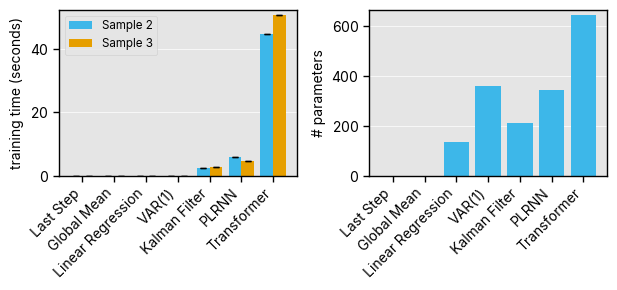

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
from plotting_utils import bars, adjust_ylim

model_labels = {
                    'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    # 'hierarchized-clipped-shallow-PLRNN': 'H-PLRNN',
                    'Transformer': 'Transformer'
                    }

with PaperStyle():

    fig, axes = plt.subplots(1, 2, figsize=(6.27, 3))

    bars(training_time.unstack('MRT').loc[model_labels.keys()].T.to_numpy(), ax=axes[0], 
         yerr=training_time_errorbars.unstack('MRT').loc[model_labels.keys()].T.to_numpy().reshape(2, 2, -1))      
    axes[0].set(ylabel='training time (seconds)', xticks=range(len(model_labels)))
    axes[0].set_xticklabels(model_labels.values(), rotation=45, ha='right')
    axes[0].legend(labels=['Sample 2', 'Sample 3'])
    adjust_ylim(axes[0], 0.03, 0)
    
    axes[1].bar(range(len(model_labels)), number_of_params.loc[model_labels.keys()])            
    axes[1].set(ylabel='# parameters', xticks=range(len(model_labels)))
    axes[1].set_xticklabels(model_labels.values(), rotation=45, ha='right')
    adjust_ylim(axes[1], 0.03, 0)

#     bars(success_ratio.unstack('MRT').loc[model_labels.keys()].T.to_numpy(), ax=axes[2])
#     axes[2].set(ylabel='convergence ratio', xticks=range(len(model_labels)))
#     axes[2].set_xticklabels(model_labels.values(), rotation=45, ha='right')
#     axes[2].set_ylim(0.5, 1)
#     axes[2].legend(labels=['MRT 2', 'MRT 3'])
#     adjust_ylim(axes[2], 0.03, 0)

    plt.tight_layout()
    if SAVE:
        plt.savefig('../results/_paper/training_time_number_of_params.png', dpi=300)
    plt.show()    

In [ ]:
print(training_time.unstack('MRT'))

In [ ]:
print(number_of_params)

In [ ]:
print(success_ratio.unstack('MRT'))